### 👉 Goal: use a frozen CLIP model to check if image ↔ text embeddings align.

We’ll just do Stage 1 → Step E1.1 right now:
👉 Goal: use a frozen CLIP model to check if image ↔ text embeddings align.

You’ll:

Load a few images + captions,

Get CLIP embeddings,

Compute cosine similarities,

See if each caption matches its image.

In [1]:
import torch, random
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt


# reproducibility
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"


/storage/ice1/1/0/vchopra37/main_python_env/main_python_venv/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-10-13 21:59:45.134126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 21:59:45.194407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 21:59:47.179161: I tensorflow/core/util/por

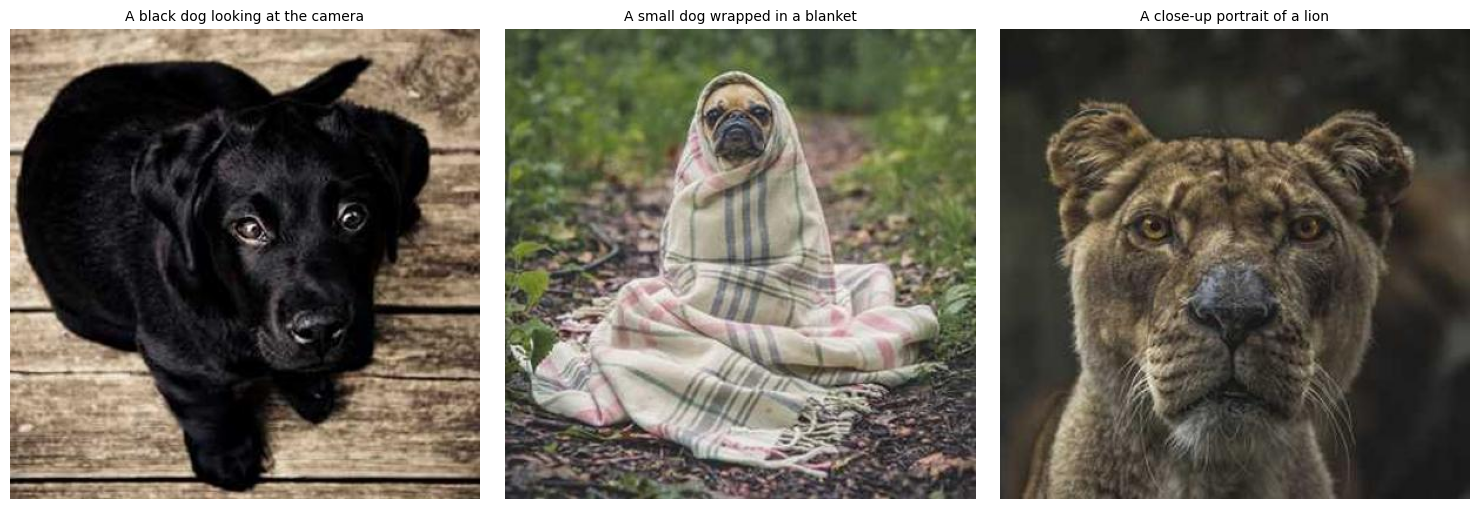

In [20]:
import matplotlib.pyplot as plt

# your images and captions
images = [
    Image.open(requests.get("https://picsum.photos/id/237/400/400", stream=True).raw),
    Image.open(requests.get("https://picsum.photos/id/1025/400/400", stream=True).raw),
    Image.open(requests.get("https://picsum.photos/id/1074/400/400", stream=True).raw)
]

captions = [
    "A black dog looking at the camera",
     "A small dog wrapped in a blanket",          # image 2 ✅
    "A close-up portrait of a lion"              # image 3 ✅
]

# plot
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

if len(images) == 1:
    axes = [axes]

for ax, img, cap in zip(axes, images, captions):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(cap, fontsize=10, wrap=True)

plt.tight_layout()
plt.show()


In [21]:
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# embed images
with torch.no_grad():
    inputs = processor(images=images, return_tensors="pt").to(device)
    img_emb = model.get_image_features(**inputs)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

# embed texts
with torch.no_grad():
    inputs = processor(text=captions, return_tensors="pt", padding=True).to(device)
    txt_emb = model.get_text_features(**inputs)
    txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)


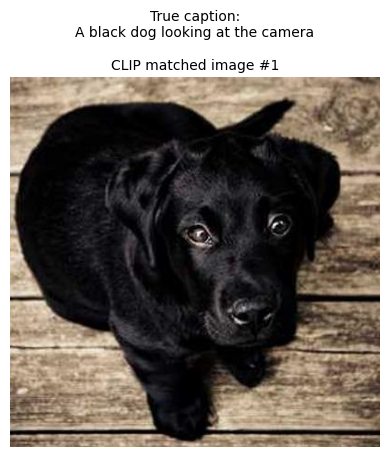

--- Similarities for caption 1 ---
Image 1: 0.317
Image 2: 0.239
Image 3: 0.193



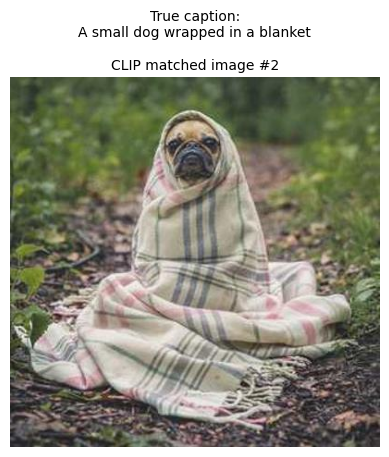

--- Similarities for caption 2 ---
Image 1: 0.205
Image 2: 0.303
Image 3: 0.145



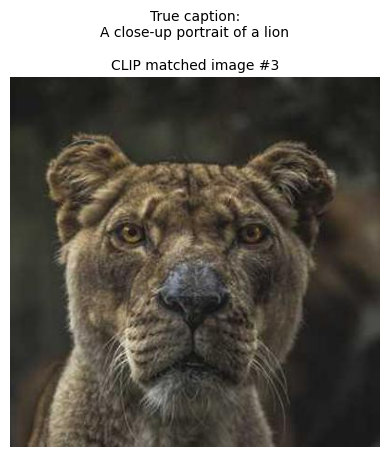

--- Similarities for caption 3 ---
Image 1: 0.185
Image 2: 0.183
Image 3: 0.317



In [22]:
# cosine similarity matrix
sims = txt_emb @ img_emb.T
sims_np = sims.cpu().numpy()

for i, cap in enumerate(captions):
    best_idx = torch.argmax(sims[i]).item()

    # show the image
    plt.imshow(images[best_idx])
    plt.axis("off")
    plt.title(f"True caption:\n{cap}\n\nCLIP matched image #{best_idx+1}", fontsize=10)
    plt.show()

    print(f"--- Similarities for caption {i+1} ---")
    for j, val in enumerate(sims_np[i]):
        print(f"Image {j+1}: {val:.3f}")
    print()


### Goal: check whether Whisper’s audio embeddings align with MiniLM’s text embeddings.
We’ll keep it as simple and visual as before — small dataset, frozen models, cosine similarity, clear output.

In [23]:
import torch, torchaudio
from transformers import WhisperProcessor, WhisperModel
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [24]:
import io
import requests
import torchaudio

samples = [
    {
        "url": "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/1.flac",
        "caption": "A man is speaking calmly"
    },
    {
        "url": "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/2.flac",
        "caption": "A person is laughing loudly"
    },
    {
        "url": "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/3.flac",
        "caption": "A dog is barking"
    }
]

audios, captions = [], []
for s in samples:
    # ✅ download to bytes buffer, then read with torchaudio
    resp = requests.get(s["url"])
    wav_bytes = io.BytesIO(resp.content)
    wav, sr = torchaudio.load(wav_bytes)
    audios.append((wav.mean(0), sr))
    captions.append(s["caption"])

print("Loaded", len(audios), "audio clips successfully ✅")


Loaded 3 audio clips successfully ✅


/storage/ice1/1/0/vchopra37/main_python_env/main_python_venv/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [25]:
# Whisper encoder (for audio)
whisper_name = "openai/whisper-tiny"
whisper = WhisperModel.from_pretrained(whisper_name).to(device).eval()
whisper_proc = WhisperProcessor.from_pretrained(whisper_name)

# MiniLM (for text)
text_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)


In [26]:
a_emb = []
for wav, sr in tqdm(audios, desc="Audio → Whisper"):
    # Make sure it's a single 1D numpy array
    audio_np = wav.squeeze().numpy()
    inputs = whisper_proc([audio_np], sampling_rate=sr, return_tensors="pt").to(device)

    with torch.no_grad():
        feats = whisper.encoder(inputs.input_features).last_hidden_state.mean(dim=1)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    a_emb.append(feats.cpu())
a_emb = torch.cat(a_emb, dim=0)


Audio → Whisper: 100%|██████████| 3/3 [00:00<00:00, 215.64it/s]


In [ ]:
# compute text embeddings for captions
t_emb = torch.tensor(
    text_model.encode(captions, convert_to_numpy=True, normalize_embeddings=True)
)


Caption 1: A man is speaking calmly
Best-matched audio index: 2
Similarity scores: [-0.014  0.019 -0.004]


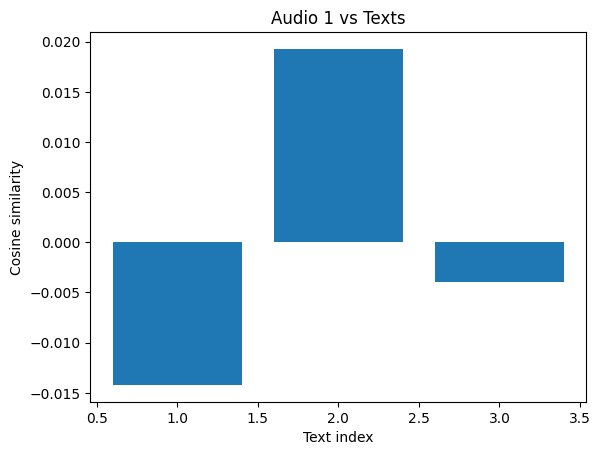


Caption 2: A person is laughing loudly
Best-matched audio index: 2
Similarity scores: [ 0.006  0.042 -0.027]


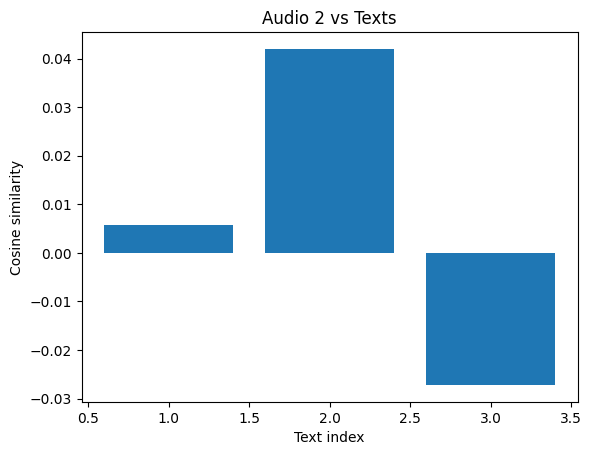


Caption 3: A dog is barking
Best-matched audio index: 2
Similarity scores: [ 0.002  0.038 -0.012]


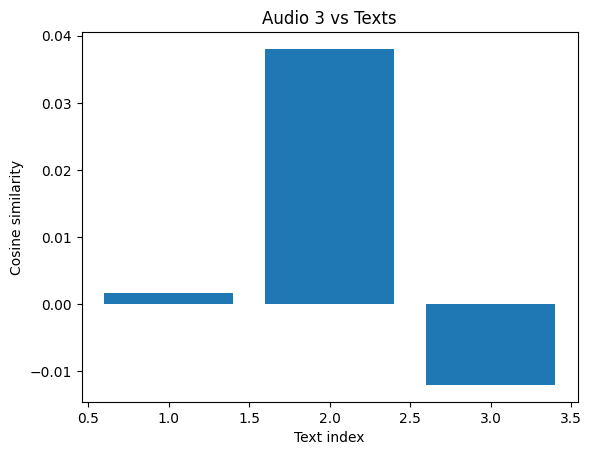

In [28]:
sims = (a_emb @ t_emb.T).cpu().numpy()

for i, cap in enumerate(captions):
    best = sims[i].argmax()
    print(f"\nCaption {i+1}: {cap}")
    print(f"Best-matched audio index: {best+1}")
    print("Similarity scores:", sims[i].round(3))

    # Simple bar plot
    plt.bar(range(1, len(audios)+1), sims[i])
    plt.title(f"Audio {i+1} vs Texts")
    plt.xlabel("Text index"); plt.ylabel("Cosine similarity")
    plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ensure everything is numpy
a_np = a_emb.numpy()
t_np = t_emb.numpy()
i_np = img_emb.cpu().numpy()

In [30]:
a_np.shape

(3, 384)

In [31]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

common_dim = min(2, t_np.shape[0], i_np.shape[0])  # safe value
pca_t = PCA(n_components=common_dim).fit(t_np)
pca_i = PCA(n_components=common_dim).fit(i_np)

t_proj = pca_t.transform(t_np)
i_proj = pca_i.transform(i_np)

sim_t_i = cosine_similarity(t_proj, i_proj)


In [32]:
# 1️⃣ Audio → Text similarity
sim_a_t = cosine_similarity(a_np, t_np)

In [33]:
# pick the best-matching text for each audio
best_text_idx = np.argmax(sim_a_t, axis=1)


In [34]:
# # 2️⃣ Text → Image similarity (CLIP space)
# sim_t_i = cosine_similarity(t_np, i_np)
sim_a_i = sim_a_t[np.arange(len(best_text_idx)), best_text_idx][:, None] * sim_t_i[best_text_idx]
best_img_idx = np.argmax(sim_a_i, axis=1)


In [35]:
# compute final Audio → Image score through the text pivot
sim_a_i = sim_a_t[np.arange(len(best_text_idx)), best_text_idx][:, None] * sim_t_i[best_text_idx]

# for each audio, get the image with the highest combined similarity
best_img_idx = np.argmax(sim_a_i, axis=1)



Audio 1 predicted best image: 2
Matched caption: A person is laughing loudly


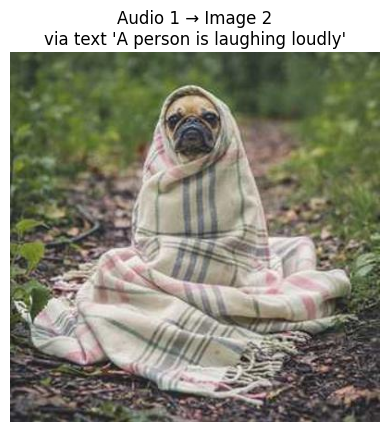


Audio 2 predicted best image: 2
Matched caption: A person is laughing loudly


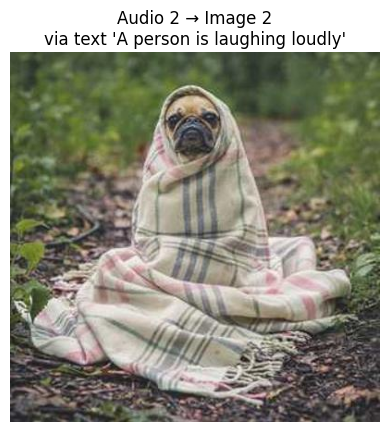


Audio 3 predicted best image: 2
Matched caption: A person is laughing loudly


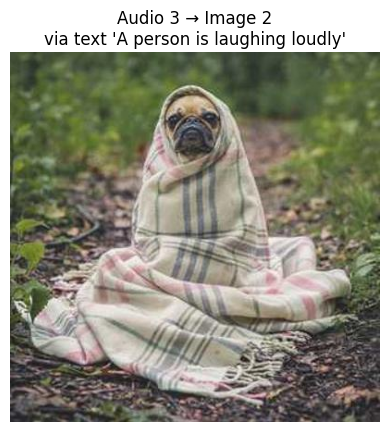

In [36]:
for n, (audio_idx, img_idx) in enumerate(zip(range(len(best_img_idx)), best_img_idx)):
    print(f"\nAudio {audio_idx+1} predicted best image: {img_idx+1}")
    print("Matched caption:", captions[best_text_idx[audio_idx]])

    plt.imshow(images[img_idx])
    plt.axis("off")
    plt.title(f"Audio {audio_idx+1} → Image {img_idx+1}\nvia text '{captions[best_text_idx[audio_idx]]}'")
    plt.show()


# Title: “Zero-shot Image–Text Retrieval (CLIP-ViT-B/16)”

Objective: Show that a frozen vision-language model already aligns images ↔ captions.

Setup: CLIP ViT-B/16, COCO-2017 val, N=12 pairs, no training.

Procedure: Encode images & captions → cosine similarity → retrieval.

Metrics: Acc@1 (caption→image), similarity heatmap, top-3 qualitative results.

Takeaway: CLIP gets strong text↔image alignment out-of-the-box → a solid baseline to compare against.

In [40]:
# ! pip install seaborn

In [56]:
from datasets import load_dataset
from itertools import islice

# streaming = True lets us pull just a few samples quickly
ds = load_dataset("allenai/pixmo-cap", split="train", streaming=True)

# take 2 samples only
samples = list(islice(ds, 2))

print(f"Loaded {len(samples)} examples")
for i, s in enumerate(samples):
    print(f"\nSample {i+1} caption:\n{s['caption'][:200]} ...")


Loaded 2 examples

Sample 1 caption:
This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathe ...

Sample 2 caption:
This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of motion and speed. The viewer sees the motorcycle's handlebars and front dash, inc ...


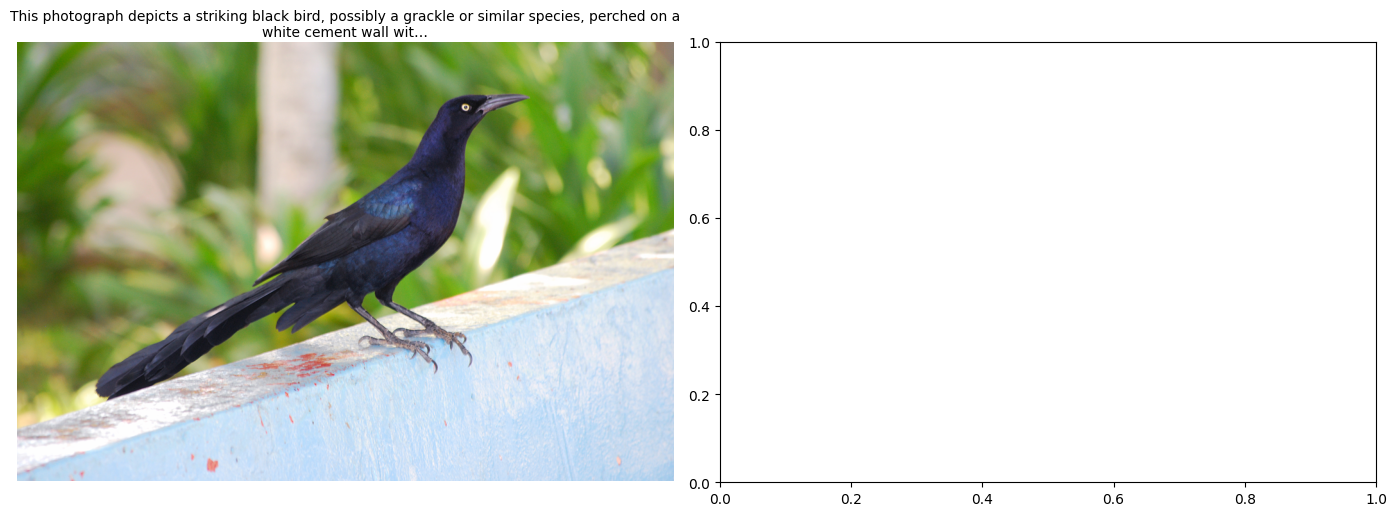

In [63]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(samples), figsize=(14, 5))
if len(samples) == 1:
    axes = [axes]

for ax, s in zip(axes, samples):
    img = Image.open(requests.get(s["image_url"], stream=True).raw).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(s["caption"][:120] + "…", fontsize=10, wrap=True)
    break
plt.tight_layout()
plt.show()


In [60]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns, requests
from PIL import Image
from datasets import load_dataset
from itertools import islice
from transformers import AutoModel, AutoProcessor
from tqdm import tqdm

In [59]:
pairs = []
for ex in islice(ds, 60):  # overfetch a bit to skip any bad rows
    cap = ex.get("caption", None)
    url = ex.get("image_url", None)
    if not cap or not url:
        continue
    try:
        img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    except Exception:
        continue
    pairs.append((img, cap))
    if len(pairs) == N:
        break

images = [im for im, _ in pairs]
captions = [tx for _, tx in pairs]
print(f"Loaded {len(images)} PixMo samples")


Loaded 12 PixMo samples


In [61]:

# ---------- SigLIP model ----------
model_id = "google/siglip-base-patch16-224"
model = AutoModel.from_pretrained(model_id).to(device).eval()         # returns SiglipModel
proc  = AutoProcessor.from_pretrained(model_id)                       # returns SiglipProcessor


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Acc@1 (caption→image): 1.00


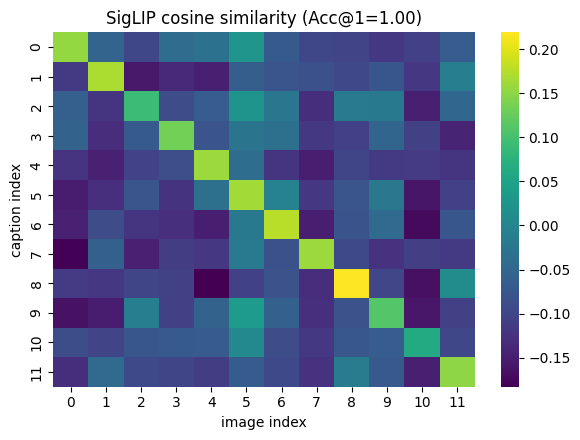

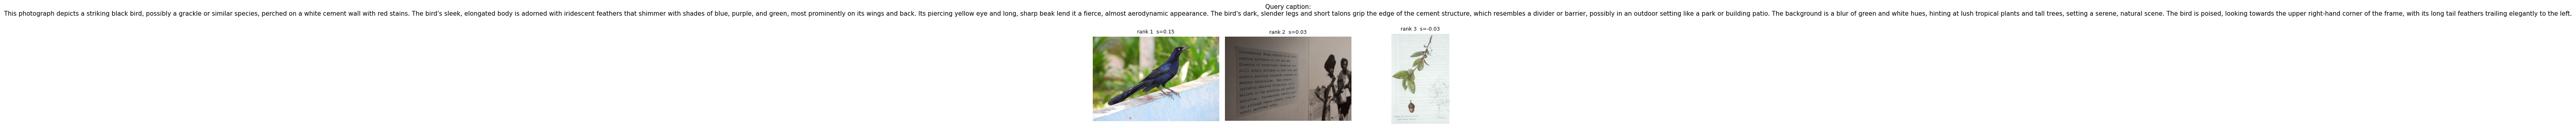

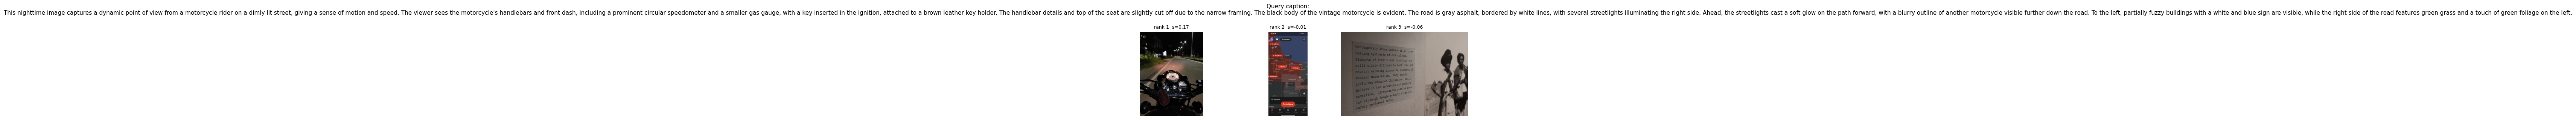

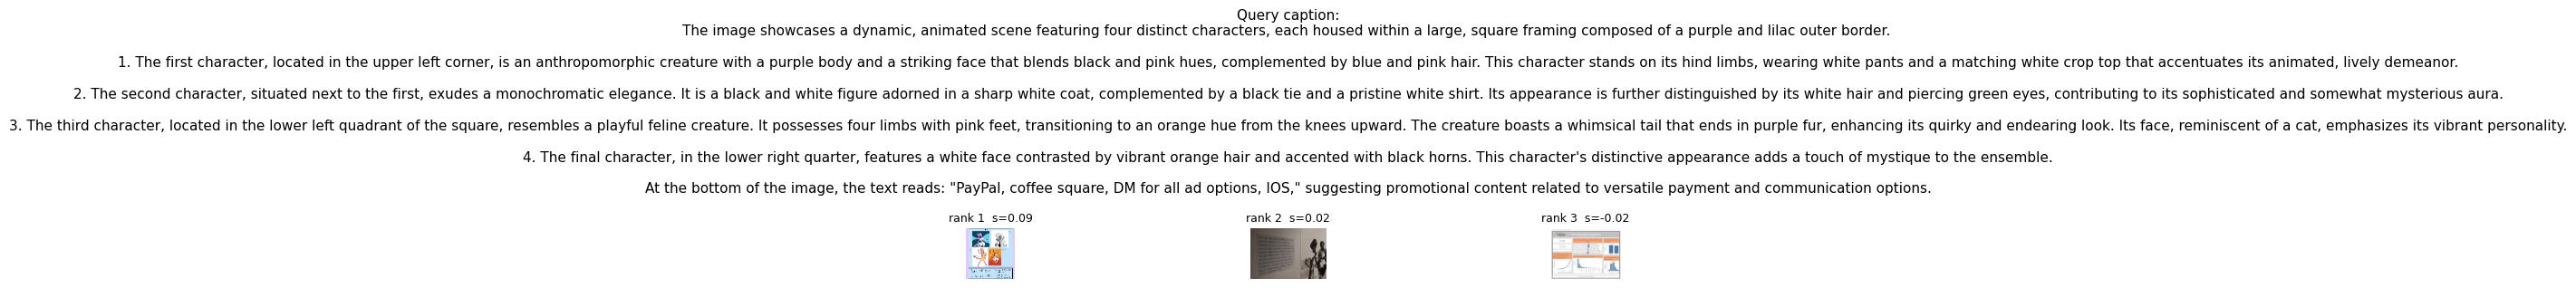

In [62]:


# ---------- Embeddings (normalized) ----------
with torch.no_grad():
    img_emb = model.get_image_features(**proc(images=images, return_tensors="pt").to(device))
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    txt_emb = model.get_text_features(**proc(text=captions, return_tensors="pt", padding=True, truncation=True).to(device))
    txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)

# ---------- Similarity & Acc@1 ----------
S = (txt_emb @ img_emb.T).detach().cpu().numpy()   # [N_text, N_img]
pred = S.argmax(axis=1)
acc1 = (pred == np.arange(len(captions))).mean()
print(f"Acc@1 (caption→image): {acc1:.2f}")

# ---------- Figure A: Heatmap ----------
plt.figure(figsize=(6, 4.5))
sns.heatmap(S, annot=False, cmap="viridis")
plt.xlabel("image index"); plt.ylabel("caption index")
plt.title(f"SigLIP cosine similarity (Acc@1={acc1:.2f})")
plt.tight_layout()
plt.savefig("siglip_heatmap.png", dpi=200)
plt.show()

# ---------- Figure B: Top-3 retrieval gallery ----------
def show_topk_gallery(k_ids=(0,1,2), topk=3):
    for cid in k_ids:
        order = np.argsort(-S[cid])[:topk]
        fig, axes = plt.subplots(1, topk, figsize=(10, 3.2))
        for j, ax in enumerate(axes):
            ax.imshow(images[order[j]]); ax.axis("off")
            ax.set_title(f"rank {j+1}  s={S[cid, order[j]]:.2f}", fontsize=9)
        fig.suptitle(f"Query caption:\n{captions[cid]}", fontsize=11)
        plt.tight_layout()
        plt.savefig(f"siglip_top{topk}_caption{cid}.png", dpi=200)
        plt.show()

show_topk_gallery(k_ids=tuple(range(min(3, len(captions)))), topk=3)
